# Notebook version of import file

In [ ]:
# !pip install requests
# !pip install numpy
# !pip install seaborn
# !pip install pandas
# !pip install scipy
# !pip install matplotlib
# !pip install nilearn
# !pip install nimare
# !pip install duecredit
# !pip install mne

In [ ]:
import os
import requests
import datetime
import mne
import numpy as np
import seaborn as sns
import pandas as pd
from scipy import signal
from matplotlib import rcParams
from matplotlib import pyplot as plt
from nilearn import plotting
from nimare import utils

/root/venv/lib/python3.7/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


## Data analysis functions

In [ ]:
def download(fname, url):
	if not os.path.isfile(fname):
		print("Loading file...")
		try:
			r = requests.get(url)
		except requests.ConnectionError:
			print("!!! Failed to download data !!!")
		else:
			if r.status_code != requests.codes.ok:
				print("!!! Failed to download data !!!")
			else:
				with open(fname, "wb") as fid:
					fid.write(r.content)


def load(fname):
	data = np.load(fname, allow_pickle=True)['dat']
	return data

def trial_v1(data, subject, trial):

	raw = data[subject][trial]
	dataframe = pd.DataFrame(data=raw['V'], columns=["Channel " + str(i) for i in range(len(raw['V'][1]))])
	dataframe.insert(0, "Time", pd.to_datetime(np.arange(0, len(raw['V'])), unit='ms', origin=0))
	dataframe.insert(len(dataframe.columns), "Stimulus On", '', allow_duplicates=True)
	dataframe['Stimulus On'] = 0
	for event in raw['t_on']:
		dataframe.at[event, 'Stimulus On'] = 1

	return dataframe

def trial(data, subject, trial):
	return data[subject][trial]

def trial_df(data, subject, trial):
	raw = data[subject][trial]

	dataframe = pd.DataFrame(data=None, columns=['Time', 'Channel', 'Voltage', 'Stimulus On', 'Stimulus Off', 'Response', 'Expected'])

	for channel in range(len(raw['V'][0])):
		cframe = pd.DataFrame()
		cframe.insert(0, "Time", pd.to_datetime(np.arange(0, len(raw['V'])), unit='ms', origin=0))
		cframe.insert(1, "Channel", channel*np.ones(len(raw['V'])))
		cframe.insert(2, "Voltage", raw['V'][:, channel], allow_duplicates=True)
		cframe.insert(3, "Stimulus On", np.zeros(len(raw['V'])), allow_duplicates=True)
		cframe.insert(4, "Stimulus Off", np.zeros(len(raw['V'])), allow_duplicates=True)
		cframe.insert(5, "Response", np.zeros(len(raw['V'])), allow_duplicates=True)
		cframe.insert(6, "Expected", np.zeros(len(raw['V'])), allow_duplicates=True)
		cframe.at[raw['t_on'], "Stimulus On"] = True
		cframe.at[raw['t_off'], "Stimulus Off"] = True
		#cframe.at[raw['t_on'], "Response"] = raw['response'] == 1
		#cframe.at[raw['t_on'], "Expected"] = raw['target'] == 1
		dataframe = dataframe.append(cframe, ignore_index=True)

	return dataframe

def trial_mne(data, subject, trial):
	raw = data[subject][trial]
	data = np.swapaxes(raw['V'], 0, 1)
	info = mne.create_info(data.shape[0], 1000)

	package = mne.io.RawArray(data, info)

	return package

def time_lock(data, subject, trial, before=-400, after=1600):
	data = data[subject][trial]
	V = data['V']
	nt, nchan = V.shape
	nstim = len(data['t_on'])

	trange = np.arange(before, after)
	ts = data['t_on'][:,np.newaxis] + trange
	aligned = np.reshape(V[ts, :], (nstim, after - before, nchan))
	
	
	on = data['t_on']
	response = data['response']
	expected = data['target']
	rt = data['rt']

	return aligned, on, response, expected, rt

def trial_epoch(data, subject, trial, before=-400, after=1600):
	event_id = dict(wrong_response=0, correct_response=1)
	aligned, on, response, expected, rt = time_lock(data, subject, trial, before, after)
	data = np.swapaxes(aligned, 1, 2)
	info = mne.create_info(data.shape[1], 1000)

	# events = np.zeros((len(data), 3), dtype=int)
	# events[0] = np.arange(len(data))
	# events[1] = after-before
	# events[2] = response == expected

	events = np.vstack((np.arange(len(data)), np.ones(len(data))*(after-before), response == expected)).astype(int)

	#events = np.sort(events, axis=0)
	epochs = mne.EpochsArray(data=data, info=info, event_id=event_id, events=events)

	return epochs


def spectral_power(voltage , high_pass=50, low_pass=10):
	V = voltage.astype('float32') # always convert the voltage data to float32!

	# high-pass filter above high_pass (Hz)
	b, a = signal.butter(3, [high_pass], btype = 'high', fs=1000)
	V = signal.filtfilt(b,a,V,0)

	# compute smooth envelope of this signal = approx power
	V = np.abs(V)**2
	b, a = signal.butter(3, [low_pass], btype = 'low', fs=1000)
	V = signal.filtfilt(b,a,V,0)

	# normalize each channel so its mean power is 1
	V = V/V.mean(0)
	return V

# def time_lock(data, before, after):
# 	V = data['V']
# 	nt, nchan = V.shape
# 	nstim = len(data['t_on'])

# 	trange = np.arange(before, after)
# 	ts = data['t_on'][:,np.newaxis] + trange
# 	aligned = np.reshape(V[ts, :], (nstim, after - before, nchan))
# 	return aligned

## Visualization

In [ ]:
def visual(data):
    g=sns.FacetGrid(data, row='Channel', aspect=10)
    g.map(sns.lineplot, 'Voltage')
    return

## Running

In [ ]:
fname = 'memory_nback.npz'
url = "https://osf.io/xfc7e/download"

download(fname, url)
data = load(fname)



t = trial_df(data, subject=0, trial=1)

#np.shape(data[0][1]['V'][0])

In [ ]:
trials, t, r, e, rt = time_lock(data, 0, 1)

print(trials.shape)

e = trial_epoch(data, 0, 1, -400, 1600)
e.average().plot()


(100, 2000, 64)


ValueError: events must be of shape (N, 3), got (3, 100)

In [ ]:
t[t['Stimulus On'] == 1]

,Time,Channel,Voltage,Stimulus On,Stimulus Off,Response,Expected
6681,1970-01-01 00:00:06.681,0.0,-0.692871,True,0.0,0.0,0.0
8881,1970-01-01 00:00:08.881,0.0,-0.924805,True,0.0,0.0,0.0
11081,1970-01-01 00:00:11.081,0.0,-1.615234,True,0.0,0.0,0.0
13281,1970-01-01 00:00:13.281,0.0,-0.846191,True,0.0,0.0,0.0
15481,1970-01-01 00:00:15.481,0.0,-0.101807,True,0.0,0.0,0.0
...,...,...,...,...,...,...,...
15350761,1970-01-01 00:03:45.721,63.0,0.195435,True,0.0,0.0,0.0
15352961,1970-01-01 00:03:47.921,63.0,0.948730,True,0.0,0.0,0.0
15355161,1970-01-01 00:03:50.121,63.0,1.972656,True,0.0,0.0,0.0
15357361,1970-01-01 00:03:52.321,63.0,0.165649,True,0.0,0.0,0.0


alt.Chart(...)

In [ ]:
for s in range(2):
    for i in range(1,4):
        l = np.count_nonzero(data[s][i]['response']==1)
        if l:
            mean = np.mean(data[s][i]['response']==data[s][i]['target'])
            print("Subject {s} responded {l} times in trial {i} with {m}% accuracy.".format(s=s+1, l=l, i=i+1, m=mean*100))
        else:
            print("Subject {s} did not respond in trial {i}.".format(s=s+1, i=i+1))


Subject 1 responded 23 times in trial 2 with 99.0% accuracy.
Subject 1 responded 19 times in trial 3 with 97.0% accuracy.
Subject 1 responded 9 times in trial 4 with 85.0% accuracy.
Subject 2 responded 22 times in trial 2 with 98.0% accuracy.
Subject 2 responded 15 times in trial 3 with 95.0% accuracy.
Subject 2 responded 2 times in trial 4 with 82.0% accuracy.


In [ ]:
s = 0
t = 3
data[s][t]['response']==data[s][t]['target']


for s in data:
    for it, t in enumerate(s):
        for ist, stim in enumerate(t['response']):
            if stim == 1:
                
                output[it][ist] += 1

output

IndexError: list index out of range

In [ ]:
m = trial_mne(data, 0, 1)

Creating RawArray with float64 data, n_channels=64, n_times=240080
    Range : 0 ... 240079 =      0.000 ...   240.079 secs
Ready.


<RawArray | 64 x 240080 (240.1 s), ~117.3 MB, data loaded>


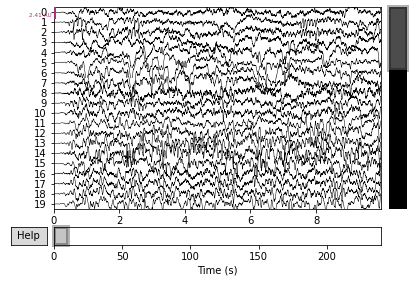

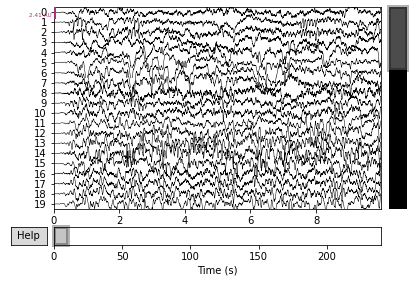

In [ ]:
print(m)
m.plot()

In [ ]:
trial_epoch(data, 0, 1)


Creating RawArray with float64 data, n_channels=64, n_times=240080
    Range : 0 ... 240079 =      0.000 ...   240.079 secs
Ready.


ValueError: Data must be a 3D array of shape (n_epochs, n_channels, n_samples)

# Epoch structures

## Everything from one subject
* Epochs of num_epochs

# Response (each entry)
* Voltages (all channels: time*64)
* ~~func(operation, voltage_segment)~~ 
* Response (True or False)
* Expected Respose (True or False)
* Response RT

Info about epoch zero-locking
* Length
* Offset before
* Offset after



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7ed4159f-8b09-4220-a447-166d33697ecf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>